### Neuroevolution:

- Allgemein:
    - Bei jeder Mutation gibt es eine mutation rate (wie viele Parameter werden verändert) und mutation strength (wie stark werden die ausgewählten parameter mutiert werden)
    - Mutationen basieren auf Gaussian noise
    - Die agents, die für die nächste Generation mutiert werden sollen, werden mithilfe von fitness proportional selection (roulette wheel selection) ausgewählt. Vorher wird die fitness allerdings normalisiert und softmax angewandt (Temperatur ist Hyperparameter)
    - Elitismus: Die besten n (Hyperparameter) Agents pro Generation werden unverändert direkt in die nächste Generation übernommen
    - Jede Generation hat exakt viele Agenten
    - Die nächste Generation basiert immer auf den Eliten + mutierten Nachkommen von Selektierten (Eliten machen bei der roulette wheel selection mit)
    - Agent bricht nach ersten Tod ab bzw nach max steps ab
    - Es wird der standard reward von super mario gym benutzt

- Klassenaufteilung:

    - NeuroevolutionNet:
        - Konfigurierbares neuronales Netz bestehend aus CNN + MLP.
        - Flexible Layer-Definition via cnn_config / mlp_config
        - Gewichtsinitialisierung mit Xavier init
        - Mutiert mit zufälligen hinzufügen von gaussian noise

    - NeuroevolutionAgent:
        - Führt Preprocessing des Beobachtungsbildes durch (Graustufen, Resize, Normalisierung).
        - Wählt Aktion per argmax(logits) aus dem Netzoutput.
        - Bewertet Episode berechnet Gesamtfitness
        - Erkennt eigenen Tod (erster Tod ist permanent, nur 1 von 3 Leben wird genutzt)

    - NeuroevolutionTrainer:
        - Führt den gesamten evolutionären Trainingsprozess durch
        - Startpopulation erzeugen (Kopien des Basisnetzes).
        - Agenten evaluieren und selektieren (roulette wheel selection ).
        - Neue Generation erzeugen (inkl. Elitismus).
        - Speichert Fitnessmetriken (best/avg/min).
        - Zeichnet bestes Modell im Video auf
        - Plot der Fitnessverläufe (matplotlib), Speicherung als PNG.
        - Speichert bestes model und kann model laden


##### ToDo:
- Hilfsplott mit wichtigen Informationen zum aktuellen training: Anzahl in Prozent wie viele Agenten aus Mutationen von Eliteagenten in aktueller Generation enstanden sind
- Dynamische Mutation (z.B: erhöhe Mutationsstärke bei Stillstand)

##### Nice to have:
- Verbesserung der GPU Auslastung (Hat sich als schwierig herausgestellt, im Moment ist cpu-only schneller!)
- Frame skipping um performance zu erhöhen (Auch schwierig hauptlast ist nicht die entscheidung des agenten sondern die laufende mario umgebung)
- Percentage clipping für die eliteagents?

## Ideen:
- Finden einer Lösung für alle Level
- Finden der schnellsten Lösung für ein Level
- Analysieren, was das cnn von (ausgewählten, wie zb die besten) agenten sieht
- Training mit allen agenten aus random_hyperparameter_search_1 als startagents (z.B. pop 100, gens 100, hohe temperatur, elitism 5)
- Training mit den 10 besten agenten aus r_h_s_1 (z.B. pop 100, gens 100, elitism 10)
- In sinnvollen Bereich gridsearch durchführen
- Manuelles auswerten der Videos und "gut aussehende" Agenten als Elite in ein neues Training übernehmen
- Analyse der rhs1 Daten
- Überprüfen ob Agent auch in anderen Leveln gut abschneidet
- Finden eines super-Agenten der so viele Level wie möglich schaffen kann

# Random Hyperparameter Search 1

Es werden 100 Runs mit zufälligen Hyperparametern gemacht

In [ ]:
import random
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

# Constants
CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]
MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]
ENV_NAME = 'SuperMarioBros-1-1-v0'
ACTION_SET = RIGHT_ONLY
DEVICE = "cpu"
DIRECTORY = "../../runs/neuroevolution/random_hyperparameter_search_1"
GENERATIONS = 20
POPULATION_SIZE = 50
MAX_STEPS_PER_EPISODE = 2500

# Hyperparameter search ranges
MUTATION_RATE_SELECTION_INTERVAL = (0.00, 0.3)

MUTATION_STRENGTH_SELECTION_INTERVAL = (0.00, 0.2)

ROULETTE_TEMP_MIN = 0.5
ROULETTE_TEMP_MAX = 2.0

ELITISM_OPTIONS = [0, 1, 2, 3, 4, 5]

for _ in range (100):
    model = NeuroevolutionNet(
        input_channels=1,
        num_actions=len(RIGHT_ONLY),
        cnn_config=CNN_CONFIG,
        mlp_config=MLP_CONFIG
    )

    r1 = round(random.uniform(*MUTATION_RATE_SELECTION_INTERVAL), 2)
    r2 = round(random.uniform(*MUTATION_RATE_SELECTION_INTERVAL), 2)
    mutation_rate_range = tuple(sorted((r1, r2)))

    r1 = round(random.uniform(*MUTATION_STRENGTH_SELECTION_INTERVAL), 2)
    r2 = round(random.uniform(*MUTATION_STRENGTH_SELECTION_INTERVAL), 2)
    mutation_strength_range = tuple(sorted((r1, r2)))

    roulette_wheel_selection_temperature = round(random.uniform(ROULETTE_TEMP_MIN, ROULETTE_TEMP_MAX), 2)
    elitism = random.choice(ELITISM_OPTIONS)

    trainer = NeuroevolutionTrainer(
        base_model=model,
        env_name=ENV_NAME,
        action_set=ACTION_SET,
        device=DEVICE,
        directory=DIRECTORY,
        generations=GENERATIONS,
        population_size=POPULATION_SIZE,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        mutation_rate_range=mutation_rate_range,
        mutation_strength_range=mutation_strength_range,
        roulette_wheel_selection_temperature=roulette_wheel_selection_temperature,
        elitism=elitism
    )
    trainer.run()
    trainer.record_best_agent()
    trainer.save_metrics()
    trainer.save_best_model()

# Exploitation test 1

Bester Agent aus random_hyperparameter_search_1 wird genommen und maximal exploited, falls besserer agent raus kommt, wiederhole mit diesen agenten <br>
Versuch (aus rhs_1) max_fit_2125__avg_fit_267__env_name_SuperMarioBros-1-1-v0__action_set_5 -> max_fit_2360__avg_fit_422__env_name_SuperMarioBros-1-1-v0__action_set_5 <br>
Versuch (aus et_1) max_fit_2360__avg_fit_422__env_name_SuperMarioBros-1-1-v0__action_set_5 -> max_fit_2360__avg_fit_447__env_name_SuperMarioBros-1-1-v0__action_set_5 (keine verbesserung) <br>
Versuch (aus et_1) max_fit_2360__avg_fit_447__env_name_SuperMarioBros-1-1-v0__action_set_5 -> max_fit_2749__avg_fit_609__env_name_SuperMarioBros-1-1-v0__action_set_5 <br>
Versuch (aus et_1) max_fit_2749__avg_fit_609__env_name_SuperMarioBros-1-1-v0__action_set_5 -> max_fit_3047__avg_fit_1060__env_name_SuperMarioBros-1-1-v0__action_set_5 (level geschafft)

In [ ]:
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

# Constants
CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]
MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]
MODEL = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(RIGHT_ONLY),
    cnn_config=CNN_CONFIG,
    mlp_config=MLP_CONFIG
)
ENV_NAME = 'SuperMarioBros-1-1-v0'
ACTION_SET = RIGHT_ONLY
DEVICE = "cpu"
DIRECTORY = "../../runs/neuroevolution/exploitation_test_1"
GENERATIONS = 100
POPULATION_SIZE = 100
MAX_STEPS_PER_EPISODE = 2500
MUTATION_RATE_RANGE = (0.00, 0.02)
MUTATION_STRENGTH_RANGE = (0.00, 0.02)
ROULETTE_WHEEL_SELECTION_TEMPERATURE = 0.01
ELITISM = 1

trainer = NeuroevolutionTrainer(
        base_model=MODEL,
        env_name=ENV_NAME,
        action_set=ACTION_SET,
        device=DEVICE,
        directory=DIRECTORY,
        generations=GENERATIONS,
        population_size=POPULATION_SIZE,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        mutation_rate_range=MUTATION_RATE_RANGE,
        mutation_strength_range=MUTATION_STRENGTH_RANGE,
        roulette_wheel_selection_temperature=ROULETTE_WHEEL_SELECTION_TEMPERATURE,
        elitism=ELITISM
    )

trainer.load_model("../../runs/neuroevolution/exploitation_test_1/max_fit_2749__avg_fit_609__env_name_SuperMarioBros-1-1-v0__action_set_5/best_model_2749.0.pt")
trainer.run()
trainer.record_best_agent()
trainer.save_metrics()
trainer.save_best_model()

# Promising Hyperparameter Test 1
Nehme die Hyperparameter von einen Training mit guten max und avg fitness und wiederhole den test mit mehr generationen. Benutze Hyperparameter von (rht_1) max_fit_1863__avg_fit_292__env_name_SuperMarioBros-1-1-v0__action_set_5

1. Ergebnis: max_fit_2237__avg_fit_399__env_name_SuperMarioBros-1-1-v0__action_set_5 ziemlich gute, verdächtig logarithmisch aussehende fitness kurve => es wird wahrscheinlich mutation rate / strength decay benötigt, für bessere ergebnisse
2. wiederhole erneut für Bestätigung. Ergebnis: max_fit_2352__avg_fit_369__env_name_SuperMarioBros-1-1-v0__action_set_5 (wieder ungefähr dasselbe problem, bestätigt die Vermutung das man mutation decay braucht) <br>
3. wiederhole jetzt mit mutation decay. Ergebnis: max_fit_3048__avg_fit_718__env_name_SuperMarioBros-1-1-v0__action_set_5 (extreme Verbesserung, man sieht wann der decay stärker wird, avg fitness zum schluss bei 2000 anstatt bei 500 (!), es wurde eine lösung für das level gefunden)

In [ ]:
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

# Constants
CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]
MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]
MODEL = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(RIGHT_ONLY),
    cnn_config=CNN_CONFIG,
    mlp_config=MLP_CONFIG
)
ENV_NAME = 'SuperMarioBros-1-1-v0'
ACTION_SET = RIGHT_ONLY
DEVICE = "cpu"
DIRECTORY = "../../runs/neuroevolution/promising_hyperparameter_test_1"
GENERATIONS = 200
POPULATION_SIZE = 50
MAX_STEPS_PER_EPISODE = 2500
MUTATION_RATE_RANGE = (0.14, 0.25)
MUTATION_STRENGTH_RANGE = (0.14, 0.19)
ROULETTE_WHEEL_SELECTION_TEMPERATURE = 0.98
ELITISM = 4
MUTATION_RATE_SIGMOID_DECAY = {"a": 0.05, "b": 0.058, "c": 100}
MUTATION_STRENGTH_SIGMOID_DECAY = {"a": 0.05, "b": 0.058, "c": 100}

trainer = NeuroevolutionTrainer(
        base_model=MODEL,
        env_name=ENV_NAME,
        action_set=ACTION_SET,
        device=DEVICE,
        directory=DIRECTORY,
        generations=GENERATIONS,
        population_size=POPULATION_SIZE,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        mutation_rate_range=MUTATION_RATE_RANGE,
        mutation_strength_range=MUTATION_STRENGTH_RANGE,
        roulette_wheel_selection_temperature=ROULETTE_WHEEL_SELECTION_TEMPERATURE,
        elitism=ELITISM,
        mutation_rate_sigmoid_decay=MUTATION_RATE_SIGMOID_DECAY,
        mutation_strength_sigmoid_decay=MUTATION_STRENGTH_SIGMOID_DECAY
    )

trainer.run()
trainer.record_best_agent()
trainer.save_metrics()
trainer.save_best_model()

# Individual Level Training 1

Da der promising_hyperparameter_test_1/max_fit_3048__avg_fit_718__env_name_SuperMarioBros-1-1-v0__action_set_5 so ein großer Erfolg war, versuche ich jetzt mit denselben hyperparametern jeweils eine Lösung für jedes Level zu finden

1-2 erster Versuch: max_fit_2213__avg_fit_444__env_name_SuperMarioBros-1-2-v0__action_set_5, deutlich schlechteres Ergebnis als bei 1-1 <br>
1-2 zweiter Versuch: max_fit_2017__avg_fit_437__env_name_SuperMarioBros-1-2-v0__action_set_5, wieder ein schlechtes Ergebnis, obwohl die anzahl der Generationen von 200 auf 400 verdoppelt wurde, es scheint als ob vor allen dingen von einer deutlich niedrigeren mutationsrate/stärke profitiert wird und die phase mit hoher mutationsrate/stärke nur anfänglich etwas gebracht hat, bis so Generation 20?? Es gab nur leichte verbesserungen bis so gen 100 in der explorationsphase. Vielleicht sind 2,5k steps für dieses level einfach zu wenig für eine gute exploration/explotation? <br>
1-2 dritter Versuch: max_fit_2042__avg_fit_423__env_name_SuperMarioBros-1-2-v0__action_set_5, max steps wurden von 2,5k auf 5k erhöht, generationen wurde von 400 auf 200 verringert, trotzdem immer noch relativ schlechtes ergebnis <br>
1-2 vierter Versuch: max steps bleiben auf 5k, die decayfunktion wurde angepasst, sodass, der decay früher beginnt und es einen längeren übergang auf niedrigere decay werte gibt. Min decay von 5 prozent auf 1 prozent verringert. Trotzdem werden die gens von 200 auf 300 angehoben, damit es eine noch längere explotationsphase/fintuningphase gibt

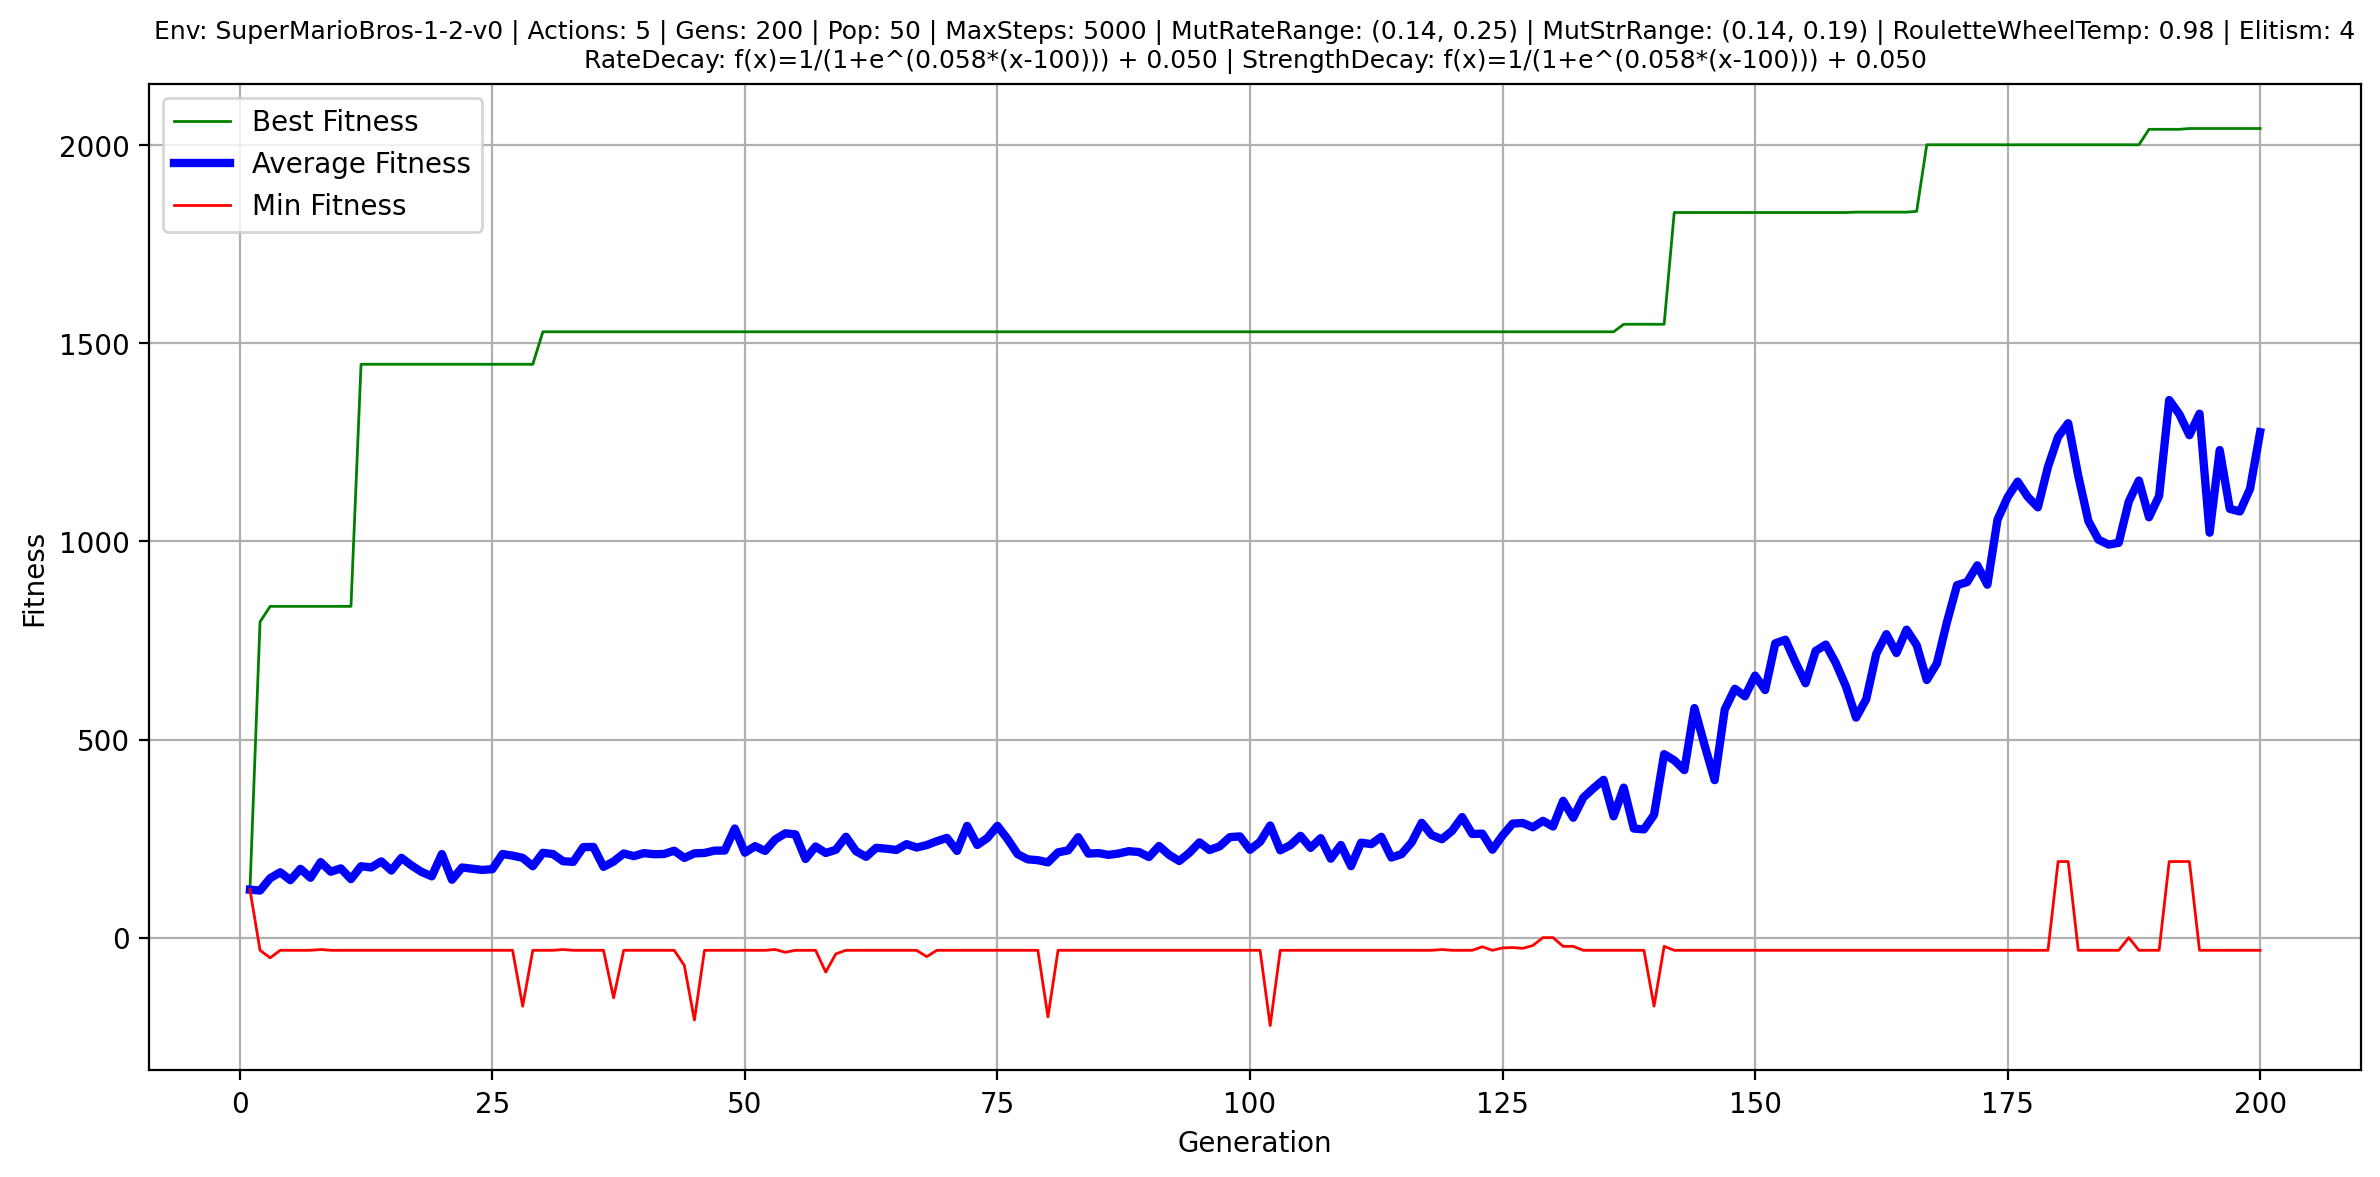

C:\Users\savew\miniconda3\envs\mario_2\lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\mario\SuperMarioReinforcementLearningProject\runs\neuroevolution\individual_level_training_1\1-2\max_fit_2042__avg_fit_423__env_name_SuperMarioBros-1-2-v0__action_set_5 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\savew\miniconda3\envs\mario_2\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
C:\Users\savew\miniconda3\envs\mario_2\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps


Running best agent for recording...

Final fitness: 2042.00
Video saved to: ../../runs/neuroevolution/individual_level_training_1/1-2\max_fit_2042__avg_fit_423__env_name_SuperMarioBros-1-2-v0__action_set_5\fitness_2042.0.mp4
Fitness plot saved to ../../runs/neuroevolution/individual_level_training_1/1-2\max_fit_2042__avg_fit_423__env_name_SuperMarioBros-1-2-v0__action_set_5\fitness_plot.png
Best model saved to ../../runs/neuroevolution/individual_level_training_1/1-2\max_fit_2042__avg_fit_423__env_name_SuperMarioBros-1-2-v0__action_set_5/best_model_2042.0.pt


In [1]:
from src.non_reinforcement.neuroevolution.neuroevolution_trainer import NeuroevolutionTrainer
from src.non_reinforcement.neuroevolution.neuroevolution_net import NeuroevolutionNet
from gym_super_mario_bros.actions import RIGHT_ONLY
%config InlineBackend.figure_format = 'retina'

# Constants
CNN_CONFIG = [
    {"out_channels": 16, "kernel_size": 8, "stride": 4},
    {"out_channels": 32, "kernel_size": 4, "stride": 2},
]
MLP_CONFIG = [
    32 * 9 * 9,  # Must match flattened output of CNN
    256,
    128,
    len(RIGHT_ONLY)
]
MODEL = NeuroevolutionNet(
    input_channels=1,
    num_actions=len(RIGHT_ONLY),
    cnn_config=CNN_CONFIG,
    mlp_config=MLP_CONFIG
)
ENV_NAME = 'SuperMarioBros-1-2-v0'
ACTION_SET = RIGHT_ONLY
DEVICE = "cpu"
DIRECTORY = "../../runs/neuroevolution/individual_level_training_1/1-2"
GENERATIONS = 200
POPULATION_SIZE = 50
MAX_STEPS_PER_EPISODE = 5000
MUTATION_RATE_RANGE = (0.14, 0.25)
MUTATION_STRENGTH_RANGE = (0.14, 0.19)
ROULETTE_WHEEL_SELECTION_TEMPERATURE = 0.98
ELITISM = 4
MUTATION_RATE_SIGMOID_DECAY = {"a": 0.05, "b": 0.058, "c": 100}
MUTATION_STRENGTH_SIGMOID_DECAY = {"a": 0.05, "b": 0.058, "c": 100}

trainer = NeuroevolutionTrainer(
        base_model=MODEL,
        env_name=ENV_NAME,
        action_set=ACTION_SET,
        device=DEVICE,
        directory=DIRECTORY,
        generations=GENERATIONS,
        population_size=POPULATION_SIZE,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        mutation_rate_range=MUTATION_RATE_RANGE,
        mutation_strength_range=MUTATION_STRENGTH_RANGE,
        roulette_wheel_selection_temperature=ROULETTE_WHEEL_SELECTION_TEMPERATURE,
        elitism=ELITISM,
        mutation_rate_sigmoid_decay=MUTATION_RATE_SIGMOID_DECAY,
        mutation_strength_sigmoid_decay=MUTATION_STRENGTH_SIGMOID_DECAY
    )

trainer.run()
trainer.record_best_agent()
trainer.save_metrics()
trainer.save_best_model()